In [1]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ujson as json
import calendar
import datetime, time
import time as t
import scipy
import numpy as np

#The explode and bbox functions are used to get the bounding box of a geoJSON object
def explode(coords):
    """Explode a GeoJSON geometry's coordinates object and yield coordinate tuples.
    As long as the input is conforming, the type of the geometry doesn't matter."""
    for e in coords:
        if isinstance(e, (float, int, long)):
            yield coords
            break
        else:
            for f in explode(e):
                yield f

def bbox(f):
    x, y = zip(*list(explode(f['geometry']['coordinates'])))
    return np.min(x), np.min(y), np.max(x), np.max(y)

start=t.time()
filename='Ogallala.json'
with open(filename, 'r') as f:
    points = json.load(f)
with open('MajorAquifers.json','r') as f:
    utah=json.load(f)

AquiferShape= {
    'type':'FeatureCollection',
    'features':[]
}
for i in utah['features']:
    if i['properties']['AQ_NAME']=="OGALLALA":#Full_Name #AQ_NAME TRINITY
        AquiferShape['features'].append(i) 
lonmin, latmin, lonmax, latmax = bbox(AquiferShape['features'][0])
print lonmin,latmin,lonmax,latmax
lonmin,latmin,lonmax,latmax=round(lonmin*4)/4-.125,round(latmin*4)/4-.125,round(lonmax*4)/4+.125,round(latmax*4)/4+.125
latgrid = np.mgrid[latmin:latmax:.25]
longrid = np.mgrid[lonmin:lonmax:.25]
print latgrid,longrid

-103.06473477586468 31.743415186462016 -100.00006302301045 36.50123206589308
[31.625 31.875 32.125 32.375 32.625 32.875 33.125 33.375 33.625 33.875
 34.125 34.375 34.625 34.875 35.125 35.375 35.625 35.875 36.125 36.375] [-103.125 -102.875 -102.625 -102.375 -102.125 -101.875 -101.625 -101.375
 -101.125 -100.875 -100.625 -100.375 -100.125]


In [2]:
csv="jacknife_texas.csv"
jack_df=pd.read_csv(csv)
test_df=jack_df.head(5)
print(test_df)

      Well
0  1003903
1  1006909
2  1007701
3  1008102
4  1009601


21884


/home/student/tethys/miniconda/envs/tethys/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


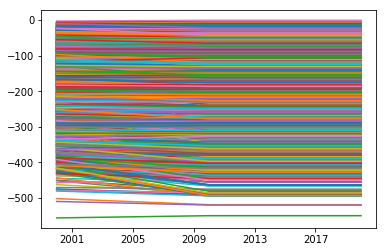

779.692303181
done


In [3]:
jacknife=1006909
start_date=2000
end_date=2010
interval=10
resolution=.05
time_tolerance=5
min_ratio=.5
min_samples=20
iterations=int((end_date-start_date)/interval+1)
start_time=calendar.timegm(datetime.datetime(start_date, 1, 1).timetuple())
end_time=calendar.timegm(datetime.datetime(end_date, 1, 1).timetuple())
time_u = "Y"
time_v=0
if interval <= .5:
    sixmonths = True
    time_u="M"
    time_v=6
    iterations += 1
    if interval == .25:
        threemonths = True
        iterations += 2
        time_v=3
else:
    time_v=int(interval)
resample_rate=str(time_v)+time_u
print len(points['features'])
start=t.time()
wells_df=pd.DataFrame()
for well in points['features']:
    exception=False
    welli=well['properties']['HydroID']
    if 'TsTime' in well:
        if len(well['TsTime'])>=min_samples:
            listlength = len(well['TsTime'])
            length_time = end_time - start_time
            mylength_time = min(well['TsTime'][listlength - 1] - well['TsTime'][0], well['TsTime'][listlength - 1] - start_time, end_time-well['TsTime'][0])
            ratio = abs((float(mylength_time) / length_time))
            if ratio > min_ratio:
                df = pd.DataFrame(index=pd.to_datetime(well['TsTime'], unit='s', origin='unix'), data=well['TsValue'],\
                                        columns=[welli])
                df=df[np.logical_not(df.index.duplicated())]
                try:
                    wells_df=pd.concat([wells_df,df], join="outer", axis=1)
                except:
                    exception=True
                    print "exception"
                    continue
wells_df=wells_df.interpolate(method='pchip',limit_area='inside')[str(start_date-1):str(end_date-1)].resample('3M').mean()
wells_df=wells_df.interpolate('nearest',limit=4*time_tolerance,limit_direction='both',fill_value="extrapolate").resample(resample_rate).nearest()
plt.plot(wells_df)
plt.show()
print t.time()-start
print "done"

In [4]:
wells_df.to_csv("Texas_Well_df.csv")

In [5]:
csv="Texas_Well_df.csv"
wells_df=pd.read_csv(csv, index_col=0)

In [6]:
try:
    wells_df.drop(jacknife,axis=1,inplace=True)
except:
    wells_df.drop(str(jacknife),axis=1,inplace=True)

In [7]:
newinterpolation_df=wells_df
lons=[]
lats=[]
values=[]
elevations=[]
ids=[]
mylon=[]
mylat=[]
myelevs=[]
myids=[]
for wellid in newinterpolation_df.columns:
    for well in points['features']:
        if wellid==str(well['properties']['HydroID']) or wellid==well['properties']['HydroID']:
            mylon.append(well['geometry']['coordinates'][0])
            mylat.append(well['geometry']['coordinates'][1])
            myelevs.append(well['properties']['LandElev'])
            myids.append(str(wellid))
            print(wellid)
            break
print("finished coordinates")
mylon=np.array(mylon)
mylat=np.array(mylat)
myelevs=np.array(myelevs)
myids=np.array(myids)
valueslist=[]
for i in range(iterations):
    myvalue=np.array(newinterpolation_df.iloc[i].tolist())
    valueslist.append(myvalue)
    x=np.isnan(myvalue)
    myelev=np.add(np.array(myelevs),myvalue)
    lons.append(mylon[np.logical_not(x)])
    lats.append(mylat[np.logical_not(x)])
    values.append(myvalue[np.logical_not(x)])
    elevations.append(myelev[np.logical_not(x)])  
    ids.append(myids)
    print(i)
lons = np.array(lons)
lats = np.array(lats)
ids=np.array(ids)
values = np.array(values)
elevations = np.array(elevations)
valueslist=np.array(valueslist)
print lons[0]
print values[0]
print "done"


1001301
1001401
1001702
1002301
1002501
1002802
1002901
1003201
1003401
1003501
1003701
1003902
1003903
1004202
1004301
1004504
1004603
1004901
1005225
1005301
1005302
1005303
1005501
1005502
1005601
1005801
1005802
1005901
1005903
1005904
1005905
1006101
1006201
1006302
1006402
1006403
1006501
1006601
1006602
1006701
1006702
1006709
1006803
1006901
1006902
1007301
1007402
1007403
1007601
1007701
1007702
1007802
1007805
1008102
1008132
1008405
1008417
1009101
1009401
1009601
1009701
1009801
1010101
1010301
1010701
1011402
1011404
1011601
1011802
1011901
1012102
1012203
1012301
1012302
1012404
1012501
1012502
1012504
1012703
1012902
1012903
1013104
1013230
1013301
1013302
1013303
1013304
1013305
1013306
1013307
1013402
1013404
1013501
1013502
1013601
1013602
1013603
1013608
1013610
1013701
1013803
1013806
1013903
1013904
1013906
1013907
1014102
1014103
1014104
1014201
1014203
1014204
1014205
1014206
1014301
1014302
1014401
1014403
1014513
1014701
1014703
1014704
1014901
1016201
1016301


2310502
2310801
2311102
2311103
2311304
2311305
2311401
2311501
2311601
2311701
2311702
2311801
2311901
2311902
2311903
2312102
2312301
2312401
2312402
2312801
2312803
2312902
2312903
2312905
2313302
2313303
2313502
2313604
2313705
2313802
2313804
2314101
2314403
2314501
2314602
2314802
2315101
2315204
2315301
2315501
2315503
2315606
2315701
2315801
2316101
2316501
2316801
2316912
2317104
2317202
2317404
2317406
2317601
2317701
2317703
2317704
2317705
2317710
2317802
2317805
2317901
2317903
2317904
2318103
2318202
2318301
2318402
2318403
2318404
2318406
2318407
2318409
2318601
2318602
2318703
2318704
2318802
2319302
2319304
2319402
2319501
2319601
2319702
2319703
2319802
2319803
2319901
2319904
2319906
2320201
2320305
2320401
2320503
2320602
2320607
2320701
2320802
2320804
2320805
2320901
2321101
2321501
2321502
2321503
2321606
2321706
2321801
2321803
2321901
2322204
2322305
2322401
2322702
2323302
2323402
2323701
2325101
2325102
2325202
2325302
2325303
2325304
2325401
2325402
2325504


2825604
2825801
2825901
2825903
2826203
2826206
2826302
2827101
2827201
2827401
2827703
2833802
2833901
2834201
2834601
2834701
2835301
2835503
2835801
2836601
2837101
2837401
2837503
2838404
2841501
2841804
2842501
2842701
2843701
2844507
2846401
2846501
2849101
2849201
2849202
2849402
2849601
2849602
2849702
2849801
2849802
2849803
2849901
2850301
2850601
2850901
2851401
2851701
2851902
2852913
2857101
2857201
2857301
2857901
2858102
2858103
2858105
2858106
2858107
2858301
2858304
2858402
2858601
2858903
2859301
2859505
2859703
2859801
2859901
2860402
2860806
2860902
2861502
333101
333302
333501
333502
333504
333702
333801
334102
334201
334302
334501
334801
335101
335201
335303
335501
335601
335903
336301
336401
336501
336601
336602
336603
336702
337101
337801
337802
337803
337804
337901
338301
338302
338401
338402
338601
338801
338803
338901
339201
339402
339503
339601
339602
339901
340101
340701
340801
340901
340903
340904
341202
341502
341602
341603
341801
341803
341901
342101
342

In [40]:
length=len(lons[0])
print(jacklon)
print(jacknife)
print(length)
for i in range(length):
    if ids[1][i]==jacknife or int(ids[1][i])==int(jacknife):
        print("equal")
print("done")
print(ids[1])

-102.288888
1006909
2346
done
['1001301' '1001401' '1001702' ... '956602' '956902' '964301']


In [8]:
lonmin=360.0
latmin=90.0
lonmax=-360.0
latmax=-90.0
for i in points['features']:
    if i['geometry']['coordinates'][0]<lonmin:
        lonmin=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][0]>lonmax:
        lonmax=i['geometry']['coordinates'][0]
    if i['geometry']['coordinates'][1]<latmin:
        latmin=i['geometry']['coordinates'][1]
    if i['geometry']['coordinates'][1]>latmax:
        latmax=i['geometry']['coordinates'][1]
lonmin=round(lonmin-.05,1)
latmin=round(latmin-.05,1)
lonmax=round(lonmax+.05,1)
latmax=round(latmax+.05,1)
print lonmin,lonmax,latmin,latmax
print len(points['features'])

-103.1 -97.0 31.5 36.5
21884


In [9]:
import numpy as np
latgrid = np.mgrid[latmin:latmax:resolution]
longrid = np.mgrid[lonmin:lonmax:resolution]
latrange=len(latgrid)
lonrange=len(longrid)
print latrange, lonrange


100 122


In [17]:
import pygslib
outx=np.repeat(longrid,latrange)
outy=np.tile(latgrid,lonrange)
grids=[]
for i in range(0,iterations):
    params={
        'x':lons[i],
        'y':lats[i],
        'vr':values[i],
        'nx':lonrange,
        'ny':latrange,
        'nz':1,
        'xmn':lonmin,
        'ymn':latmin,
        'zmn':0,
        'xsiz':resolution,
        'ysiz':resolution,
        'zsiz':1,
        'nxdis':1,
        'nydis':1,
        'nzdis':1,
        'outx':outx,
        'outy':outy,
        'radius':2,
        'radius1':2,
        'radius2':2,
        'ndmax':15,
        'ndmin':5,
        'noct':0,
        'ktype':1,
        'idbg':0,
        'c0':0,
        'it':1,
        'cc':500,
        'aa':.2,
        'aa1':.2,
        'aa2':.2
    }
    estimate= pygslib.gslib.kt3d(params)
    print i
    array=estimate[0]['outidpower']#outest
    array2=estimate[0]['outidpower']
    grid=np.reshape(array,(lonrange,latrange))
    grid2=np.reshape(array2,(lonrange,latrange))
    x=np.isnan(grid)
    grid[x]=grid2[x]
    grids.append(grid)
grids=np.array(grids)


0
1


In [19]:
with open('MajorAquifers.json','r') as f:
    allwells = ''
    wells = f.readlines()
    for i in range(0, len(wells)):
        allwells += wells[i]
utah=json.loads(allwells)


AquiferShape= {
    'type':'FeatureCollection',
    'features':[]
}
print utah['features'][0].viewkeys()
for i in utah['features']:
    if i['properties']['AQ_NAME']=="OGALLALA":#Full_Name #AQ_NAME TRINITY
        AquiferShape['features'].append(i)

with open('shapefile.json','w') as outfile:
    json.dump(AquiferShape, outfile)
    

dict_keys([u'geometry', u'type', u'properties'])


In [20]:
from __future__ import division
import netCDF4
from netCDF4 import Dataset
import numpy as np
import os
import time as t
from scipy import interpolate
from sklearn.utils import resample
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt
import cython
volunit="Acre-ft"

interpolation_type="Kriging"

latlen=len(latgrid)
lonlen=len(longrid)
filename='testinterpolate2.nc'
h=netCDF4.Dataset(filename,'w',format="NETCDF4")
h.interpolation="Kriging Pandas Interpolation"
h.start_date=start_date
h.end_date=end_date
h.interval=interval
h.resolution=resolution
h.min_samples=min_samples
h.min_ratio=min_ratio
h.time_tolerance=time_tolerance
h.default=0
h.units='English'


time = h.createDimension("time", 0)
lat = h.createDimension("lat", latlen)
lon = h.createDimension("lon", lonlen)
hydroid=h.createDimension("hydroid", len(ids[0]))
latitude=h.createVariable("lat",np.float64,("lat"))
longitude=h.createVariable("lon",np.float64,("lon"))
time=h.createVariable("time",np.float64,("time"), fill_value="NaN")
hydroids=h.createVariable("hydroid",str,("hydroid"), fill_value="NaN")
hydroids.axis="H"

tsvalue=h.createVariable("tsvalue",np.float64,('time','hydroid'),fill_value=-9999)
tsvalue.units="ft"
tsvalue.coordinates="time hydroid"

depth=h.createVariable("depth",np.float64,('time','lon','lat'),fill_value=-999)
depth.long_name="Depth to Groundwater"
depth.units="ft"
depth.grid_mapping="WGS84"
depth.cell_measures="area: area"
depth.coordinates="time lat lon"

elevation=h.createVariable("elevation",np.float64,('time','lon','lat'),fill_value=-999)
elevation.long_name="Elevation of Groundwater"
elevation.units="ft"
elevation.grid_mapping="WGS84"
elevation.cell_measures="area: area"
elevation.coordinates="time lat lon"

drawdown=h.createVariable("drawdown",np.float64,('time','lon','lat'),fill_value=-999)
drawdown.long_name="Well Drawdown"
drawdown.units="ft"
drawdown.grid_mapping="WGS84"
drawdown.cell_measures="area: area"
drawdown.coordinates="time lat lon"

volume = h.createVariable("volume", np.float64, ('time', 'lon', 'lat'), fill_value=-9999)
volume.long_name = "Change in aquifer storage volume since " + str(start_date)
volume.units = volunit
volume.grid_mapping = "WGS84"
volume.cell_measures = "area: area"
volume.coordinates = "time lat lon"

latitude.long_name="Latitude"
latitude.units="degrees_north"
latitude.axis="Y"
longitude.long_name="Longitude"
longitude.units="degrees_east"
longitude.axis="X"
time.axis="T"
time.units='days since 0001-01-01 00:00:00 UTC'
latitude[:]=latgrid[:]
longitude[:]=longrid[:]  
hydroids[:]=ids[0,:]
year=start_date
timearray=[]#[datetime.datetime(2000,1,1).toordinal()-1,datetime.datetime(2002,1,1).toordinal()-1]
            
for i in range(0,iterations):
    print i
    timearray.append(datetime.datetime(year, 1, 1).toordinal() - 1)
    year += interval
    time[i] = timearray[i]
    tsvalue[i,:]=valueslist[i,:]
    for x in range(0,lonrange):
            depth[i,x,:]=grids[i,x,:]
            elevation[i,x,:]=grids[i,x,:]
            if i==0:
                drawdown[i,x,:]=0
            else:
                drawdown[i,x,:]=depth[i,x,:]-depth[0,x,:]

h.close()
os.system("./aquifersubset.sh %s" % (filename))
# serverpath="/home/student/tds/apache-tomcat-8.5.30/content/thredds/public/testdata/groundwater"
# destination= os.path.join(serverpath, filename)
# os.rename(filename, destination)
end=t.time()
print(end-start)



0
1
1310.55077195


In [21]:
# os.system("./aquifersubset.sh %s" % (filename))
for well in points['features']:
    if well['properties']['HydroID']==jacknife or well['properties']['HydroID']==str(jacknife):
        jacklon=well['geometry']['coordinates'][0]
        jacklat=well['geometry']['coordinates'][1]
        break
print("got him")

got him


In [22]:
import urllib
import copy
from xml.etree import cElementTree as ET
# This function returns the first and last available time from a url of a getcapabilities page located on a Thredds Server
def getTimeBounds(url):
    f=urllib.urlopen(url)
    tree=ET.parse(f)
    root=tree.getroot()
    #These lines of code find the time dimension information for the netcdf on the Thredds server
    dim=root.findall('.//{http://www.opengis.net/wms}Dimension')
    dim=dim[0].text
    times=dim.split(',')
    times.pop(0)
    timemin=times[0]
    timemax=times[-1]
    #timemin and timemax are the first and last available times on the specified url
    return timemin,timemax
#This function returns a pandas dataframe of the timeseries values of a specific layer 
#at a specific latitude and longitude from a file on a Thredds server
#server: the url of the netcdf desired netcdf file on the Thredds server to read
#layer: the name of the layer to extract timeseries information from for the netcdf file
#lat: the latitude of the point at which to extract the timeseries
#lon: the longitude of the point at which to extract the timeseries
#returns df: a pandas dataframe of the timeseries at lat and lon for the layer in the server netcdf file
def getThreddsValue(server,layer,lat,lon):
    #calls the getTimeBounds function to get the first and last available times for the netcdf file on the server
    timemin,timemax=getTimeBounds(server+"?service=WMS&version=1.3.0&request=GetCapabilities")
    #These lines properly format a url request for the timeseries of a speific layer from a netcdf on 
    #a Thredds server
    server=server+"?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS="+layer
    server=server+"&X=0&Y=0&I=0&J=0&BBOX="+str(lon)+','+str(lat)+','+str(lon+.001)+','+str(lat+.001)
    server=server+"&WIDTH=1&Height=1&INFO_FORMAT=text/xml"
    server=server+'&TIME='+timemin+'/'+timemax
    print(server)
    f = urllib.urlopen(server)
    tree=ET.parse(f)
    root=tree.getroot()
    features=root.findall('FeatureInfo')
    times=[]
    values=[]
    for child in features:
        time=datetime.datetime.strptime(child[0].text,"%Y-%m-%dT%H:%M:%S.%fZ")
        times.append(time)
        values.append(child[1].text)
    
    df=pd.DataFrame(index=times, columns=[layer],data=values)
    df[layer]=df[layer].replace('none',np.nan).astype(float)
    return df

#function to convert a datetime object to milliseconds since epoch
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds


server="http://localhost:8080/thredds/wms/testAll/groundwater/testinterpolate2.nc"
layer="depth"
#calls a function to return a df of the timeseries of the pdsi at 37.7,-113
df1=getThreddsValue(server,layer,jacklat,jacklon)
print(df1)
print(jacklat,jacklon)
print(jacknife)


http://localhost:8080/thredds/wms/testAll/groundwater/testinterpolate2.nc?service=WMS&version=1.3.0&request=GetFeatureInfo&CRS=CRS:84&QUERY_LAYERS=depth&X=0&Y=0&I=0&J=0&BBOX=-102.288888,34.908055,-102.287888,34.909055&WIDTH=1&Height=1&INFO_FORMAT=text/xml&TIME=2009-12-30T00:00:00.000Z/2009-12-30T00:00:00.000Z
                depth
2009-12-30 -137.31023
(34.908055, -102.288888)
1006909
